# Import Libraries

In [99]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# Get Data

In [100]:
# Download price history of USDEUR asset
data_frame = yf.download('USDEUR=X', start='2004-04-05', end='2020-06-02', 
                         progress=False)

#Calculating the returns
data_frame['Daily_log_Return'] = np.log(data_frame['Adj Close']/
                                        data_frame['Adj Close'].shift(1))
data_frame.drop(['Open','Volume', 'Close'], axis=1, inplace=True)
data_frame.dropna(inplace=True)
data_frame.head()

,High,Low,Adj Close,Daily_log_Return
Date,,,,
2004-04-06,0.83410,0.82332,0.82433,-0.009778
2004-04-07,0.82926,0.81981,0.82196,-0.002879
2004-04-08,0.82871,0.81853,0.82802,0.007346
2004-04-09,0.82871,0.82556,0.82740,-0.000749
2004-04-12,0.82932,0.82672,0.82829,0.001075


# Explanatory Variables computation

In [101]:
def Historical_D_days_trend(data, D):
    return ( data/data.shift(D-1, axis=0) )-1

def StochasticOsclillator(data):
    temp_df = pd.DataFrame(data=data)
    temp_df['LowMin'] = data['Low'].rolling(window=14).min()
    temp_df['HighMax'] = data['High'].rolling(window=14).max()
    return (data['Adj Close']-temp_df['LowMin'])/(temp_df['HighMax']-temp_df['LowMin'])

def Line_trend(data, w):
    return (data['High'].rolling(window=w).max() + data['Low'].rolling(window=w).min())/2

data_frame['StochasticOsclillator'] = StochasticOsclillator(data_frame)

data_frame['3-period MA of %K %D'] = data_frame['StochasticOsclillator'].rolling(window=3).mean()

data_frame['3-period MA of %D'] = data_frame['3-period MA of %K %D'].rolling(window=3).mean()

data_frame['ConvLine'] = Line_trend(data_frame, 9)
data_frame['BaseLine'] = Line_trend(data_frame, 26)
data_frame['SenkouSpanA'] = (data_frame['BaseLine'] + data_frame['ConvLine'])/2

data_frame['Historical 4-day trend'] = Historical_D_days_trend(data_frame['Adj Close'], 4)
data_frame['Historical 8-day trend'] = Historical_D_days_trend(data_frame['Adj Close'], 8)
data_frame['Historical 16-day trend'] = Historical_D_days_trend(data_frame['Adj Close'], 16)
data_frame['Historical 32-day trend'] = Historical_D_days_trend(data_frame['Adj Close'], 32)

window_size = 90

data_frame['90 day standard deviation'] = data_frame['Daily_log_Return'].rolling(window=window_size).std().dropna()

data_frame = data_frame.dropna()

Return = data_frame['Daily_log_Return']
Std = data_frame['90 day standard deviation']

# making the correct classification for the stock return

label=np.zeros(np.size(Return))

for i in range(np.size(Return)):
    if Return[i] > Std[i]: 
        #if it is positive and greater than 90 day standard deviation, label is 1
        label[i] = 1
     
    elif Return[i] < (-1*Std[i]): 
        #else if it is negative and less than -1*90 day standard deviation, label is -1
        label[i] = -1

    else:    #else label is 0
        label[i] = 0
        
        
data_frame['Label'] = label  

data_frame.drop(['High','Low','HighMax','LowMin','Adj Close', 'Daily_log_Return', 
                 '90 day standard deviation'], axis=1, inplace=True)
print(data_frame)



            StochasticOsclillator  3-period MA of %K %D  3-period MA of %D  \
Date                                                                         
2004-08-09               0.198498              0.445039           0.647568   
2004-08-10               0.238240              0.245352           0.447589   
2004-08-11               0.278443              0.238394           0.309595   
2004-08-12               0.229684              0.248789           0.244178   
2004-08-13               0.007338              0.171822           0.219668   
2004-08-16               0.052593              0.096538           0.172383   
2004-08-17               0.085828              0.048586           0.105649   
2004-08-18               0.097882              0.078768           0.074631   
2004-08-19               0.021547              0.068419           0.065258   
2004-08-20               0.149419              0.089616           0.078934   
2004-08-23               0.560058              0.243675         

# Separating explanatory variables and Labels

In [102]:
# X has all the explanatory variables in the dataframe without the last column "Label"
X = data_frame.iloc[:,0:-1].values    
y = data_frame.iloc[:,-1].values      # y is the vector "Labels"



# Train-Test split

In [103]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

y = label_binarize(y, classes=[-1, 0, 1]) #binarize y for one vs rest classification

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, 
                                                    shuffle= False)



# Feature Scaling

In [104]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

# SVM classifier

In [105]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix 
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm

classifier = OneVsRestClassifier(svm.SVC(kernel='rbf', probability=True,
                                 random_state=0))

model_SVC = classifier.fit(X_train, y_train)

#Returns the decision function of the sample for each class in the model.
y_score = model_SVC.decision_function(X_test) 

#Perform classification on the samples
y_pred_svm = model_SVC.predict(X_test)



# ROC curves, confusion matrix, Precision, recall, F1-Score, Accuracy, and AUC

For y label -1  : 
ROC curves


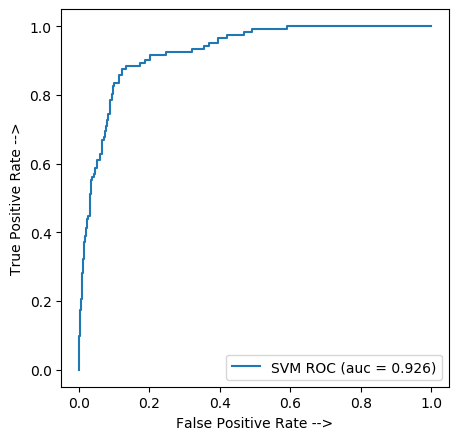

Confusion matrix
[[696   3]
 [101  20]]
Precision Recall curves


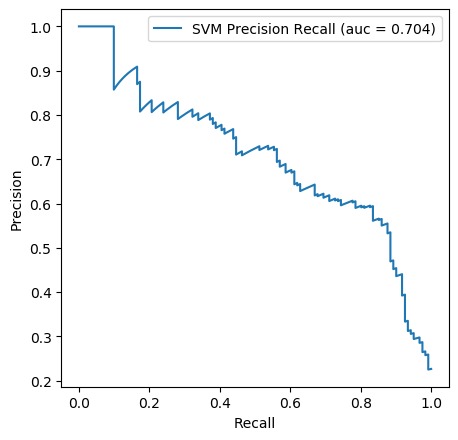

F1 score:  0.2777777777777778
Accuracy:  0.8731707317073171
AUC for ROC curve:  0.9261991747360455
AUC for Precision-Recall curve:  0.7038912955484882

For y label 0  : 
ROC curves


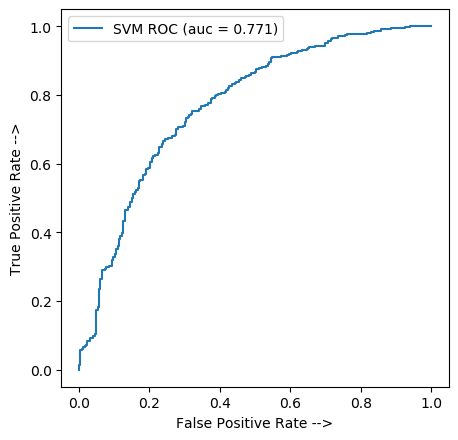

Confusion matrix
[[ 28 218]
 [  4 570]]
Precision Recall curves


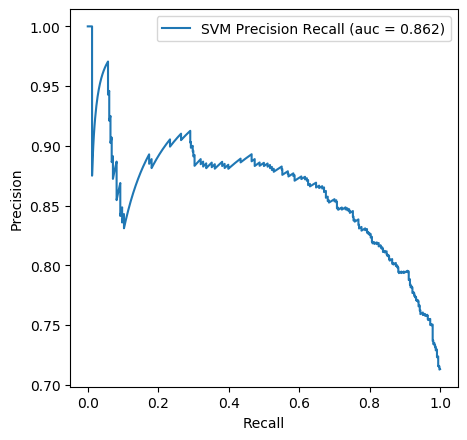

F1 score:  0.8370044052863437
Accuracy:  0.7292682926829268
AUC for ROC curve:  0.771090054106116
AUC for Precision-Recall curve:  0.8622353190732959

For y label 1  : 
ROC curves


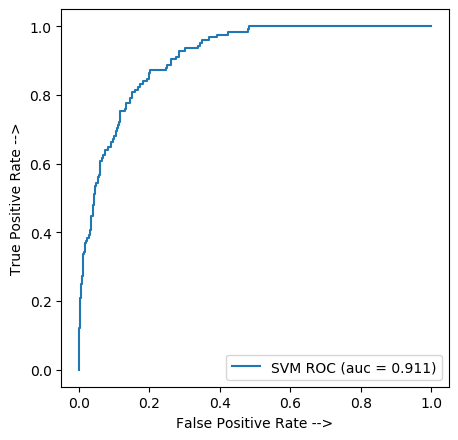

Confusion matrix
[[690   5]
 [ 98  27]]
Precision Recall curves


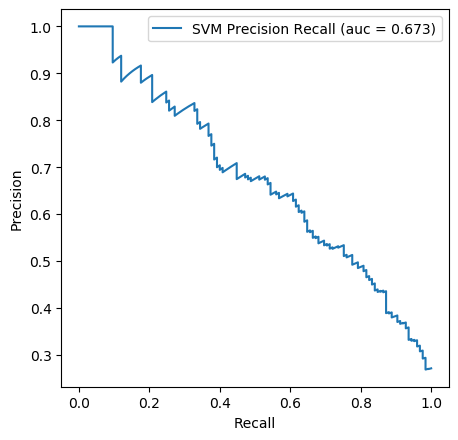

F1 score:  0.34394904458598724
Accuracy:  0.874390243902439
AUC for ROC curve:  0.9111827338129496
AUC for Precision-Recall curve:  0.6733474327764624



In [106]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
precisionrecall_auc = dict()

for i in range(3):
    
    fpr[i], tpr[i], threshold1 = roc_curve(y_test[:, i], y_score[:, i])
    
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    precision[i], recall[i], threshold2 = precision_recall_curve(y_test[:, i], 
                                                                 y_score[:, i])
    precisionrecall_auc[i] = auc(recall[i], precision[i])
    
    print("For y label",i-1, " : ")
    
    #ROC curves
    print("ROC curves")
    plt.figure(figsize=(5, 5), dpi=100)
    plt.plot(fpr[i], tpr[i], linestyle='-', label='SVM ROC (auc = %0.3f)' % roc_auc[i])

    plt.xlabel('False Positive Rate -->')
    plt.ylabel('True Positive Rate -->')

    plt.legend()

    plt.show()
    
    # creating a confusion matrix 
    cm = confusion_matrix(y_test[:, i], y_pred_svm[:, i])
    print("Confusion matrix") 
    print(cm)
    
    
    #Precision Recall curves
    print("Precision Recall curves")
    plt.figure(figsize=(5, 5), dpi=100)
    plt.plot(recall[i], precision[i], linestyle='-', 
             label='SVM Precision Recall (auc = %0.3f)' %  precisionrecall_auc[i])

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()
    
    #F1 score 
    f1 = f1_score(y_test[:, i], y_pred_svm[:, i])
    print("F1 score: ", f1)
    
    #Accuracy
    accuracy = accuracy_score(y_test[:, i], y_pred_svm[:, i])
    print("Accuracy: ", accuracy)
   
    #AUC
    print("AUC for ROC curve: " ,roc_auc[i])
    print("AUC for Precision-Recall curve: " ,precisionrecall_auc[i])
    
    print()   #new line before showing the results for the next y label
 

Start date,2017-04-06
End date,2020-06-01
Total months,39
,Backtest
Annual return,12.5%
Cumulative returns,46.8%
Annual volatility,3.5%
Sharpe ratio,3.36
Calmar ratio,36.07
Stability,0.98
Max drawdown,-0.3%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,0.35,2020-03-20,2020-03-23,2020-05-06,34
1,0.00,2017-04-06,2017-04-06,2017-04-06,1
2,0.00,2017-04-06,2017-04-06,2017-04-06,1
3,0.00,2017-04-06,2017-04-06,2017-04-06,1
4,0.00,2017-04-06,2017-04-06,2017-04-06,1


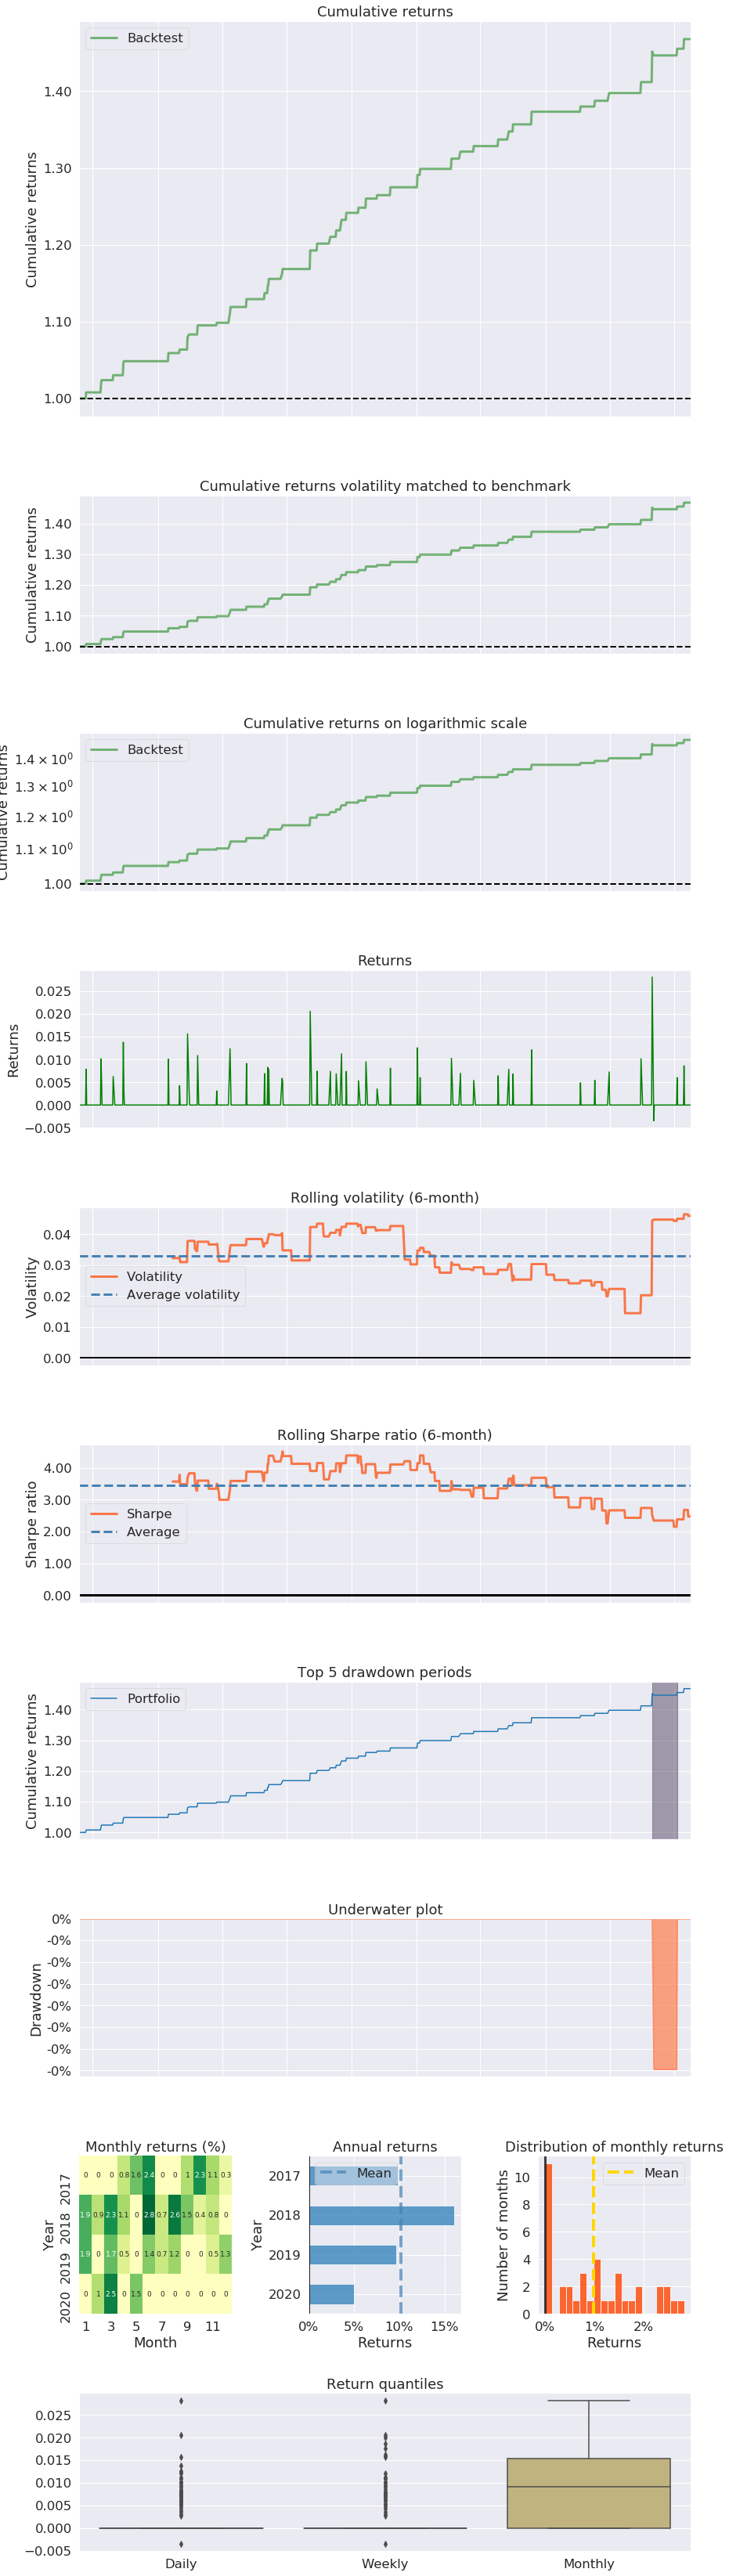

In [107]:
import pyfolio as pf
import warnings
from sklearn import preprocessing


warnings.filterwarnings('ignore')

# Binarize labels in a one-vs-all fashion
lb = preprocessing.LabelBinarizer()

lb.fit_transform([-1, 0, +1])

#choosing y_hat value to be the one which has the highest corresponding y_score
#This is to uncover the predicted return label (-1,0, or 1) from the decision function 
#score that we uncover from the SVM

y_hat = lb.inverse_transform(y_score)  


# Getting last 20% of USDEUR Return data to backtest performance of our trading strategy 

Return20 = Return.tail(len(y_hat))

#Calculating the return of our strategy which goes long (+1), short (-1), or stays 
#flat on the USDEUR asset (Long and short are always on equal units)

StrategyReturn = y_hat*Return20

import pyfolio as pf
import warnings
warnings.filterwarnings('ignore')

#Creating the Fund Factsheet
pf.create_returns_tear_sheet(StrategyReturn)

